# Введение
В этом проекте мы реализуем и обучим модель для выполнения иерархической семантической сегментации на основе датасета Pascal-part. Задача состоит в том, чтобы сегментировать изображения на несколько категорий с учетом их иерархической структуры.

In [1]:
# Установка необходимых библиотек для работы с глубоким обучением и сегментационными моделями
# В первую очередь мы устанавливаем PyTorch и другие ключевые библиотеки
!pip3 install torch torchvision albumentations segmentation-models-pytorch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
# Установка последней версии библиотеки segmentation_models_pytorch с GitHub
# Эта библиотека предоставляет предобученные модели для задач сегментации
!pip3 install -U git+https://github.com/qubvel/segmentation_models.pytorch

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-1rkprpuj
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-1rkprpuj
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit c68fc942408f7ead3fd64e866204980b05a6bfb0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 75.0 MB/s eta 0:00:00
  Created wheel for segmentation_models_pytorch: filename=segmentation_models_pytorch-0.3.4.dev0-py3-none-any.whl size=109569 sha256=5a80362a3b6f53783e54a54424ce47d958246b95420dbf3d38e902a985bf99eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-x21j6bdt/wheels/1a/49/5f/858bc2741660e381e83f1d8b297edc4d9f0561f29becaee577
Successfully built segmentation_mode

In [3]:
!python3 --version

Python 3.10.12


Загрузка датасета Pascal-part, используемого для обучения и тестирования моделей сегментации
Датасет загружается с Google Drive

In [4]:
!gdown --id 1unIkraozhmsFtkfneZVhw8JMOQ8jv78J -O pascal-part.zip

# Распаковываем архив
!unzip -q pascal-part.zip
!mv Pascal-part data
# Просмотр содержимого папки с данными для проверки успешной распаковки и организации файлов
# Убедимся, что все необходимые файлы присутствуют
!ls data

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1unIkraozhmsFtkfneZVhw8JMOQ8jv78J
From (redirected): https://drive.google.com/uc?id=1unIkraozhmsFtkfneZVhw8JMOQ8jv78J&confirm=t&uuid=a3a58964-f2a2-4613-8b52-a3656927c5c0
To: /content/pascal-part.zip
100% 419M/419M [00:15<00:00, 27.8MB/s]
classes.txt  gt_masks  JPEGImages  train_id.txt  val_id.txt


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import os
from glob import glob

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Подготовка данных
Определим класса PascalPartDataset, который будет использоваться для загрузки и предобработки данных.
Этот класс расширяет стандартный класс Dataset из PyTorch, обеспечивая загрузку изображений и масок

In [27]:
class PascalPartDataset(Dataset):
    def __init__(self, ids, images_dir, masks_dir, transform=None):
        self.ids = ids
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        image_path = os.path.join(self.images_dir, f'{image_id}.jpg')
        mask_path = os.path.join(self.masks_dir, f'{image_id}.npy')

        if not os.path.exists(image_path):
            raise FileNotFoundError(f'Image file not found: {image_path}')
        if not os.path.exists(mask_path):
            raise FileNotFoundError(f'Mask file not found: {mask_path}')

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f'Failed to read image: {image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.load(mask_path)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        mask = torch.from_numpy(mask).long()

        return image, mask


In [26]:
# Путь к данным
data_path = '/content/data'

# Чтение списков обучающих и валидационных данных
with open(os.path.join(data_path, 'train_id.txt'), 'r') as f:
    train_ids = f.read().splitlines()

with open(os.path.join(data_path, 'val_id.txt'), 'r') as f:
    val_ids = f.read().splitlines()

# Трансформации для данных
train_transform = A.Compose([
    A.Resize(256, 256),  # Приведение изображения к точному размеру 256x256
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.Normalize(),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(256, 256),  # Приведение изображения к точному размеру 256x256
    A.Normalize(),
    ToTensorV2(),
])

train_dataset = PascalPartDataset(
    ids=train_ids,
    images_dir='/content/data/JPEGImages',
    masks_dir='/content/data/gt_masks',
    transform=train_transform
)

val_dataset = PascalPartDataset(
    ids=val_ids,
    images_dir='/content/data/JPEGImages',
    masks_dir='/content/data/gt_masks',
    transform=val_transform
)

# Создаем загрузчики данных
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)


Проверим работу нового класса и путей к файлам

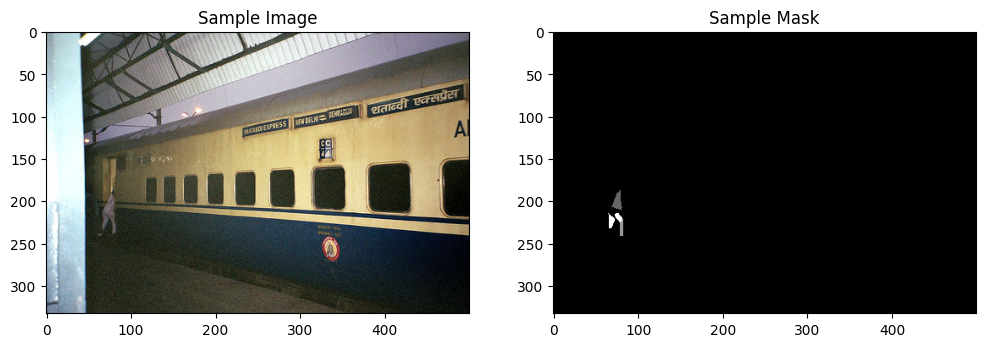

In [20]:
sample_idx = 0
dataset = PascalPartDataset(ids=train_ids, images_dir='/content/data/JPEGImages', masks_dir='/content/data/gt_masks', transform=None)
sample_image, sample_mask = dataset[sample_idx]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title('Sample Image')
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title('Sample Mask')
plt.show()


#Обучение модели

val_epoch -Функция для оценки качества модели на валидационном наборе данных. В этой функции модель переводится в режим оценки, вычисляется средняя потеря и предсказанные значения.

calculate_mIoU - Функция для расчета mIoU (mean Intersection over Union) для валидационного набора данных.

In [16]:
def val_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)

            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return epoch_loss, all_preds, all_targets

def calculate_mIoU(preds, targets, num_classes):
    ious = []
    for cls in range(num_classes):
        pred_mask = (preds == cls)
        true_mask = (targets == cls)
        iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        ious.append(iou)
    return np.mean(ious)


In [ ]:
# Функция для обучения модели на одном этапе
# В этой функции модель переводится в режим обучения, выполняется прямой проход, вычисляются градиенты и обновляются параметры модели
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images = images.to(device)
        masks = masks.to(device)

        # Сбрасываем градиенты для всех оптимизируемых переменных
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()

        # Обновляем параметры модели
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    # Вычисляем средние потери за весь обучающий набор
    epoch_loss = running_loss / len(dataloader.dataset)

    return epoch_loss

In [9]:
def visualize_predictions(model, dataloader, device, num_images=5):
    model.eval()
    images, masks = next(iter(dataloader))
    images = images[:num_images].to(device)
    masks = masks[:num_images].to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

    fig, axs = plt.subplots(num_images, 3, figsize=(12, num_images * 4))
    for i in range(num_images):
        axs[i, 0].imshow(images[i].cpu().permute(1, 2, 0))
        axs[i, 0].set_title('Image')
        axs[i, 1].imshow(masks[i].cpu().numpy())
        axs[i, 1].set_title('Ground Truth')
        axs[i, 2].imshow(preds[i])
        axs[i, 2].set_title('Prediction')

    plt.show()


In [13]:
def save_model_weights(model, model_name, epoch, save_dir='models'):
    filename = f'{save_dir}/{model_name}_epoch_{epoch}.pth'
    torch.save(model.state_dict(), filename)
    print(f'Model weights saved to {filename}')


In [10]:
# Создание директории для сохранения моделей
save_dir = 'models'
os.makedirs(save_dir, exist_ok=True)

Определение моделей для обучения
Мы будем использовать архитектуры Unet и DeepLabV3+ с различными модификациями: с и без предобученных весов. Это позволит сравнить, как использование предобученных весов влияет на результативность модели

In [17]:
models = {
    "UNet-ResNet34-Scratch": smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=7).to(device),
    "UNet-ResNet50-Scratch": smp.Unet(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=7).to(device),
    "UNet-ResNet34-Pretrained": smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=7).to(device),
    "UNet-ResNet50-Pretrained": smp.Unet(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=7).to(device),
    "DeepLabV3+-ResNet34-Scratch": smp.DeepLabV3Plus(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=7).to(device),
    "DeepLabV3+-ResNet50-Scratch": smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights=None, in_channels=3, classes=7).to(device),
    "DeepLabV3+-ResNet34-Pretrained": smp.DeepLabV3Plus(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=7).to(device),
    "DeepLabV3+-ResNet50-Pretrained": smp.DeepLabV3Plus(encoder_name="resnet50", encoder_weights="imagenet", in_channels=3, classes=7).to(device),
}

criterion = nn.CrossEntropyLoss()


In [18]:
# Функция для визуализации потерь и метрик
def plot_metrics(train_losses, val_losses, val_mIoUs, model_name):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Потери
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()

    # mIoU
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_mIoUs, 'go-', label='Validation mIoU')
    plt.xlabel('Epoch')
    plt.ylabel('mIoU')
    plt.title(f'{model_name} - mIoU')
    plt.legend()

    plt.tight_layout()
    plt.show()

Training model: UNet-ResNet34-Scratch


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.7462
Validation Loss: 0.7432
Validation mIoU: 0.1551


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.7218
Validation Loss: 0.7168
Validation mIoU: 0.1618


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.7085
Validation Loss: 0.6862
Validation mIoU: 0.1766


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.6949
Validation Loss: 0.7126
Validation mIoU: 0.1625


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.6816
Validation Loss: 0.6910
Validation mIoU: 0.1762


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.6697
Validation Loss: 0.6548
Validation mIoU: 0.1710


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.6560
Validation Loss: 0.6562
Validation mIoU: 0.1901


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.6412
Validation Loss: 0.6240
Validation mIoU: 0.2040


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.6309
Validation Loss: 0.6132
Validation mIoU: 0.2105


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.6253
Validation Loss: 0.6082
Validation mIoU: 0.2118


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.6716
Validation Loss: 0.6472
Validation mIoU: 0.2012


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.6580
Validation Loss: 0.6269
Validation mIoU: 0.2224


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.6446
Validation Loss: 0.6339
Validation mIoU: 0.2342


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.6423
Validation Loss: 0.6545
Validation mIoU: 0.2205


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.6322
Validation Loss: 0.5964
Validation mIoU: 0.2343


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.6175
Validation Loss: 0.5989
Validation mIoU: 0.2322


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.5967
Validation Loss: 0.5891
Validation mIoU: 0.2381


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.5938
Validation Loss: 0.5531
Validation mIoU: 0.2608


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.5808
Validation Loss: 0.5539
Validation mIoU: 0.2582


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.5783
Validation Loss: 0.5462
Validation mIoU: 0.2626


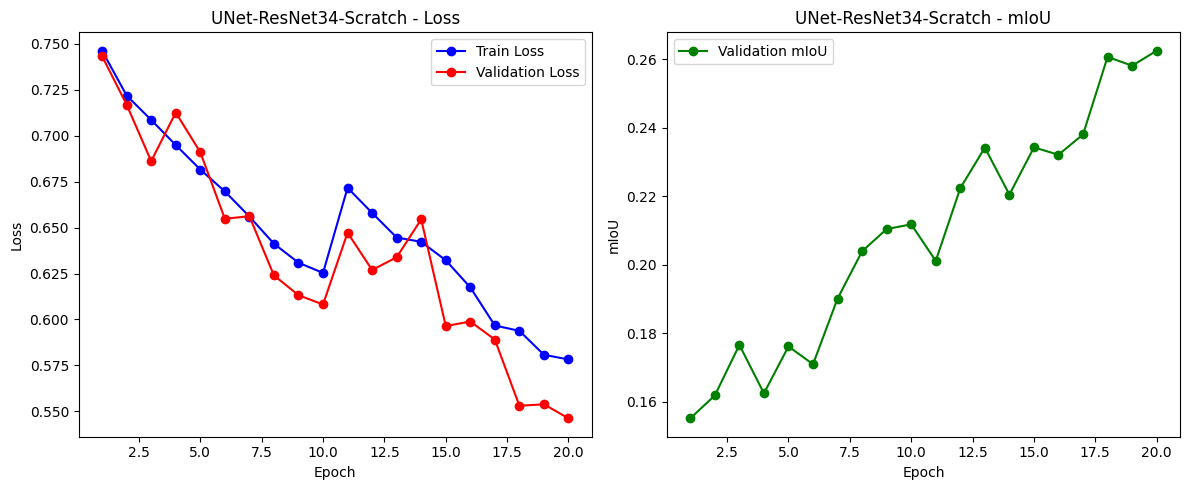

Training model: UNet-ResNet50-Scratch


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.8662
Validation Loss: 0.7862
Validation mIoU: 0.1467


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.7638
Validation Loss: 0.7611
Validation mIoU: 0.1447


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.7340
Validation Loss: 0.7200
Validation mIoU: 0.1648


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.7213
Validation Loss: 0.7166
Validation mIoU: 0.1532


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.7014
Validation Loss: 0.6900
Validation mIoU: 0.1842


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.6917
Validation Loss: 0.6807
Validation mIoU: 0.1680


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.6828
Validation Loss: 0.6742
Validation mIoU: 0.1801


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.6677
Validation Loss: 0.6614
Validation mIoU: 0.1758


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.6569
Validation Loss: 0.6443
Validation mIoU: 0.1870


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.6473
Validation Loss: 0.6347
Validation mIoU: 0.1927


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.6987
Validation Loss: 0.8378
Validation mIoU: 0.1752


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.6901
Validation Loss: 0.7543
Validation mIoU: 0.1737


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.6766
Validation Loss: 0.6592
Validation mIoU: 0.1797


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.6643
Validation Loss: 0.6967
Validation mIoU: 0.1866


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.6542
Validation Loss: 0.6308
Validation mIoU: 0.2122


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.6383
Validation Loss: 0.6293
Validation mIoU: 0.2276


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.6267
Validation Loss: 0.6198
Validation mIoU: 0.2198


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.6138
Validation Loss: 0.5932
Validation mIoU: 0.2290


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.6019
Validation Loss: 0.5851
Validation mIoU: 0.2316


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.5993
Validation Loss: 0.5701
Validation mIoU: 0.2462


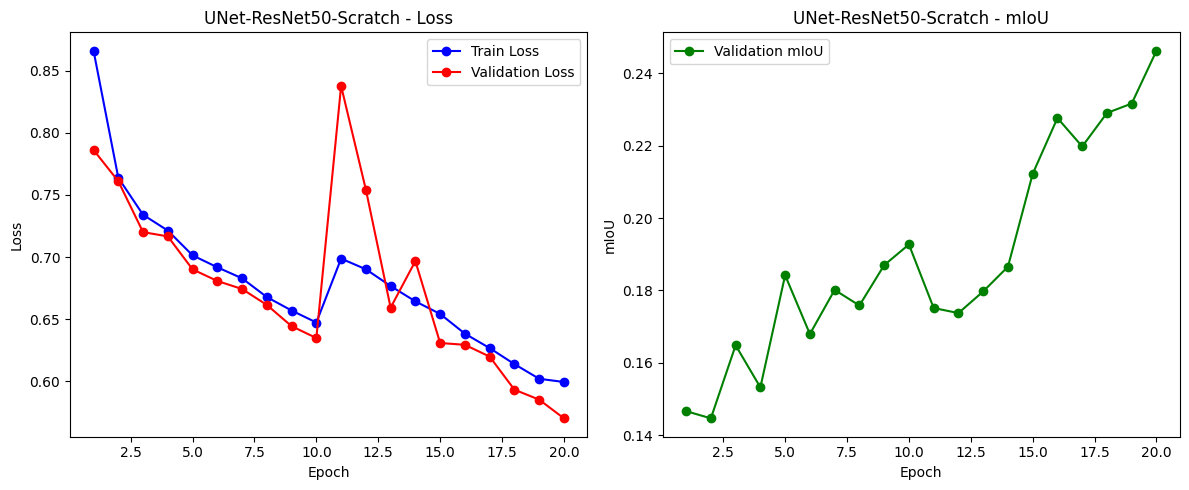

Training model: UNet-ResNet34-Pretrained


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.7747
Validation Loss: 0.6088
Validation mIoU: 0.2067


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.5942
Validation Loss: 0.5415
Validation mIoU: 0.2431


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.5506
Validation Loss: 0.5625
Validation mIoU: 0.2283


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.5097
Validation Loss: 0.5020
Validation mIoU: 0.2791


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.4850
Validation Loss: 0.4396
Validation mIoU: 0.3216


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.4573
Validation Loss: 0.4414
Validation mIoU: 0.3199


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.4343
Validation Loss: 0.3970
Validation mIoU: 0.3457


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.4056
Validation Loss: 0.3696
Validation mIoU: 0.3807


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.3811
Validation Loss: 0.3620
Validation mIoU: 0.3918


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.3733
Validation Loss: 0.3505
Validation mIoU: 0.4038


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.4782
Validation Loss: 0.4639
Validation mIoU: 0.3195


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.4650
Validation Loss: 0.4243
Validation mIoU: 0.3486


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.4366
Validation Loss: 0.3993
Validation mIoU: 0.3726


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.4234
Validation Loss: 0.4263
Validation mIoU: 0.3519


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.4029
Validation Loss: 0.4076
Validation mIoU: 0.3920


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.3859
Validation Loss: 0.3536
Validation mIoU: 0.4319


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.3596
Validation Loss: 0.3342
Validation mIoU: 0.4553


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.3405
Validation Loss: 0.3367
Validation mIoU: 0.4520


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.3233
Validation Loss: 0.3223
Validation mIoU: 0.4595


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.3196
Validation Loss: 0.3159
Validation mIoU: 0.4686


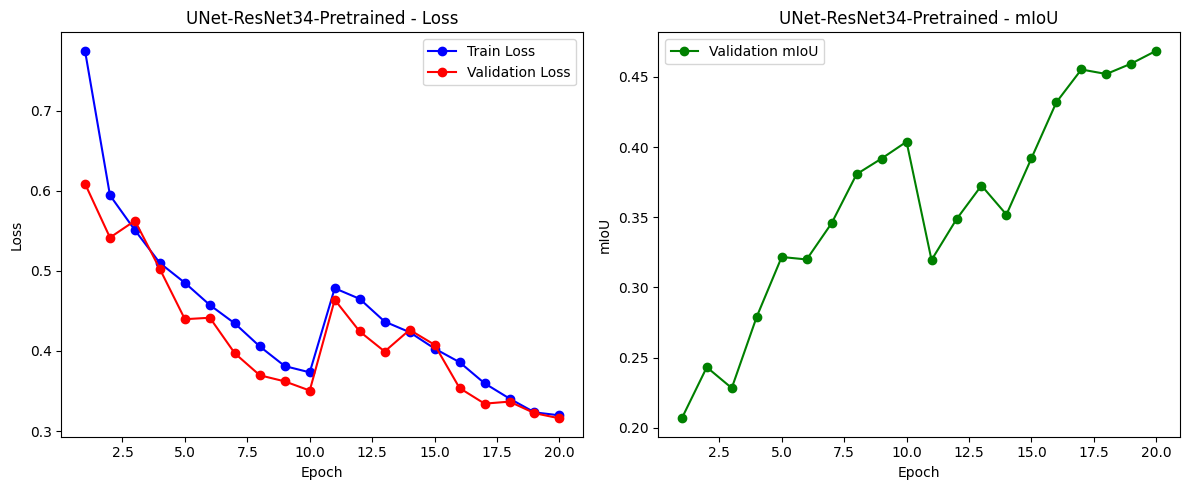

Training model: UNet-ResNet50-Pretrained


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.7940
Validation Loss: 0.6498
Validation mIoU: 0.1902


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.6108
Validation Loss: 0.5740
Validation mIoU: 0.2386


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.5655
Validation Loss: 0.5831
Validation mIoU: 0.2487


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.5263
Validation Loss: 0.5475
Validation mIoU: 0.2958


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.5018
Validation Loss: 0.4861
Validation mIoU: 0.2908


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.4705
Validation Loss: 0.4474
Validation mIoU: 0.3427


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.4470
Validation Loss: 0.4121
Validation mIoU: 0.3658


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.4192
Validation Loss: 0.3882
Validation mIoU: 0.3728


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.3920
Validation Loss: 0.3662
Validation mIoU: 0.3982


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.3761
Validation Loss: 0.3626
Validation mIoU: 0.3947


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.5022
Validation Loss: 0.5061
Validation mIoU: 0.3125


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.4880
Validation Loss: 0.5187
Validation mIoU: 0.2979


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.4651
Validation Loss: 0.4452
Validation mIoU: 0.3254


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.4404
Validation Loss: 0.4435
Validation mIoU: 0.3323


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.4231
Validation Loss: 0.3899
Validation mIoU: 0.3641


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.4024
Validation Loss: 0.3835
Validation mIoU: 0.3860


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.3818
Validation Loss: 0.3587
Validation mIoU: 0.4151


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.3572
Validation Loss: 0.3417
Validation mIoU: 0.4366


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.3437
Validation Loss: 0.3348
Validation mIoU: 0.4356


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.3318
Validation Loss: 0.3290
Validation mIoU: 0.4441


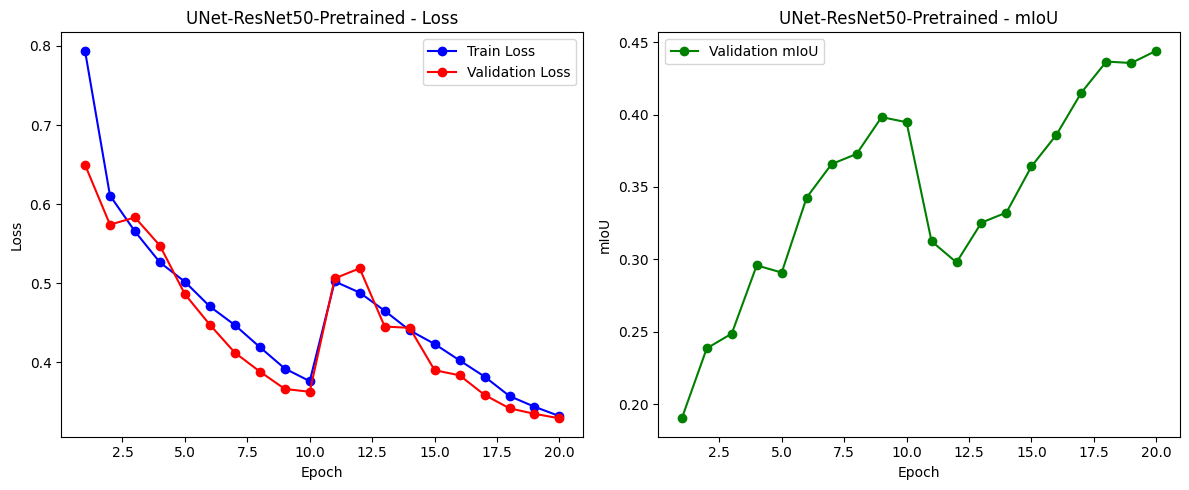

Training model: DeepLabV3+-ResNet34-Scratch


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.8257
Validation Loss: 0.7713
Validation mIoU: 0.1493


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.7551
Validation Loss: 0.7494
Validation mIoU: 0.1481


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.7325
Validation Loss: 0.7560
Validation mIoU: 0.1645


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.7122
Validation Loss: 0.7834
Validation mIoU: 0.1614


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.6975
Validation Loss: 0.6931
Validation mIoU: 0.1823


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.6762
Validation Loss: 0.7010
Validation mIoU: 0.1738


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.6623
Validation Loss: 0.7257
Validation mIoU: 0.1866


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.6478
Validation Loss: 0.6427
Validation mIoU: 0.1987


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.6387
Validation Loss: 0.6156
Validation mIoU: 0.2199


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.6309
Validation Loss: 0.6157
Validation mIoU: 0.2118


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.6912
Validation Loss: 0.6846
Validation mIoU: 0.1531


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.6705
Validation Loss: 0.6462
Validation mIoU: 0.1919


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.6601
Validation Loss: 0.6915
Validation mIoU: 0.1954


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.6483
Validation Loss: 0.6246
Validation mIoU: 0.1962


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.6407
Validation Loss: 0.5989
Validation mIoU: 0.2307


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.6164
Validation Loss: 0.5996
Validation mIoU: 0.2300


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.6035
Validation Loss: 0.5931
Validation mIoU: 0.2401


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.5918
Validation Loss: 0.5720
Validation mIoU: 0.2526


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.5809
Validation Loss: 0.5577
Validation mIoU: 0.2524


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.5726
Validation Loss: 0.5428
Validation mIoU: 0.2651


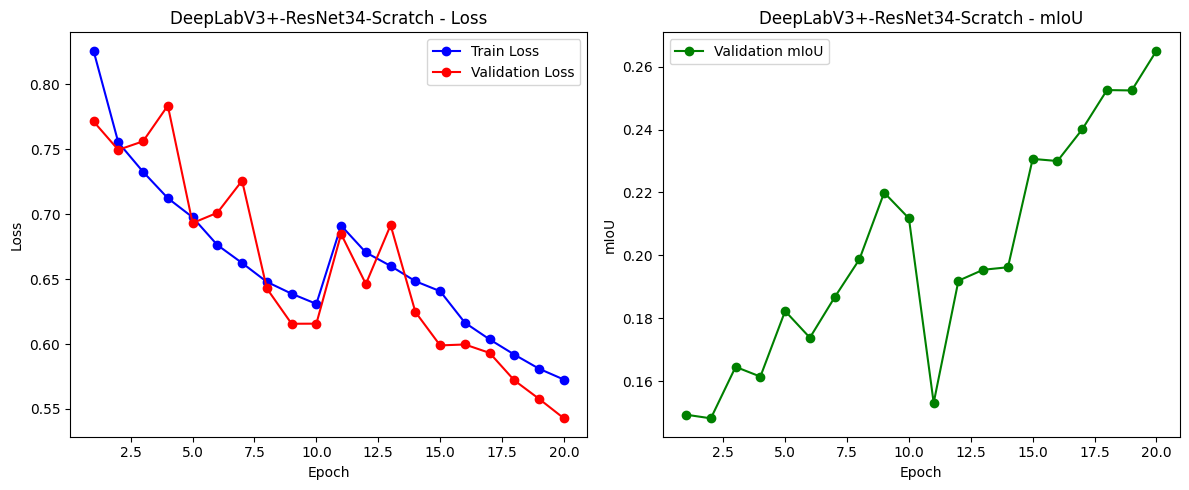

Training model: DeepLabV3+-ResNet50-Scratch


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.8174
Validation Loss: 0.9216
Validation mIoU: 0.1468


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.7432
Validation Loss: 0.7605
Validation mIoU: 0.1589


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.7114
Validation Loss: 0.7261
Validation mIoU: 0.1415


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.6978
Validation Loss: 0.6962
Validation mIoU: 0.1663


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.6867
Validation Loss: 0.7018
Validation mIoU: 0.1606


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.6697
Validation Loss: 0.6677
Validation mIoU: 0.1887


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.6526
Validation Loss: 0.6453
Validation mIoU: 0.1989


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.6385
Validation Loss: 0.6286
Validation mIoU: 0.2094


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.6226
Validation Loss: 0.5963
Validation mIoU: 0.2309


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.6177
Validation Loss: 0.5925
Validation mIoU: 0.2252


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.6847
Validation Loss: 0.6929
Validation mIoU: 0.1818


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.6645
Validation Loss: 0.6677
Validation mIoU: 0.1632


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.6481
Validation Loss: 0.6920
Validation mIoU: 0.1649


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.6331
Validation Loss: 0.6302
Validation mIoU: 0.2009


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.6284
Validation Loss: 0.6342
Validation mIoU: 0.2202


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.6090
Validation Loss: 0.6886
Validation mIoU: 0.2040


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.5954
Validation Loss: 0.5475
Validation mIoU: 0.2583


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.5784
Validation Loss: 0.5458
Validation mIoU: 0.2655


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.5645
Validation Loss: 0.5269
Validation mIoU: 0.2760


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.5593
Validation Loss: 0.5210
Validation mIoU: 0.2789


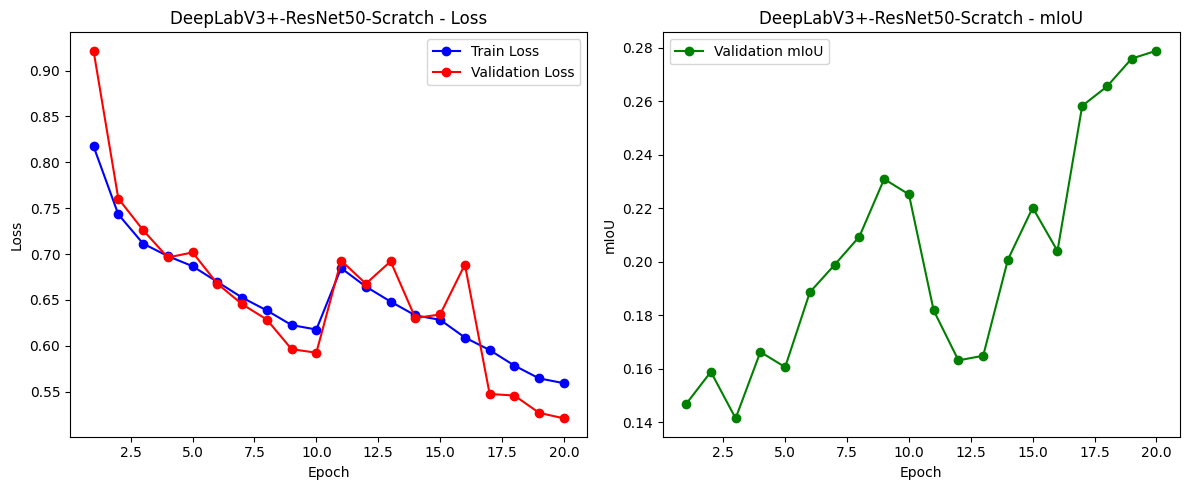

Training model: DeepLabV3+-ResNet34-Pretrained


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.6773
Validation Loss: 0.5516
Validation mIoU: 0.2442


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.5454
Validation Loss: 0.4984
Validation mIoU: 0.2917


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.5069
Validation Loss: 0.4702
Validation mIoU: 0.3150


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.4746
Validation Loss: 0.4197
Validation mIoU: 0.3497


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.4474
Validation Loss: 0.4268
Validation mIoU: 0.3572


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.4135
Validation Loss: 0.3768
Validation mIoU: 0.3956


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.3892
Validation Loss: 0.3540
Validation mIoU: 0.4163


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.3701
Validation Loss: 0.3463
Validation mIoU: 0.4264


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.3497
Validation Loss: 0.3310
Validation mIoU: 0.4402


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.3389
Validation Loss: 0.3268
Validation mIoU: 0.4437


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.4503
Validation Loss: 0.4470
Validation mIoU: 0.3519


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.4417
Validation Loss: 0.3901
Validation mIoU: 0.3730


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.4084
Validation Loss: 0.3798
Validation mIoU: 0.4063


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.3810
Validation Loss: 0.3756
Validation mIoU: 0.4032


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.3652
Validation Loss: 0.3777
Validation mIoU: 0.4122


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.3506
Validation Loss: 0.3357
Validation mIoU: 0.4449


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.3299
Validation Loss: 0.3222
Validation mIoU: 0.4531


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.3123
Validation Loss: 0.3104
Validation mIoU: 0.4697


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.2999
Validation Loss: 0.3042
Validation mIoU: 0.4803


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.2930
Validation Loss: 0.3038
Validation mIoU: 0.4746


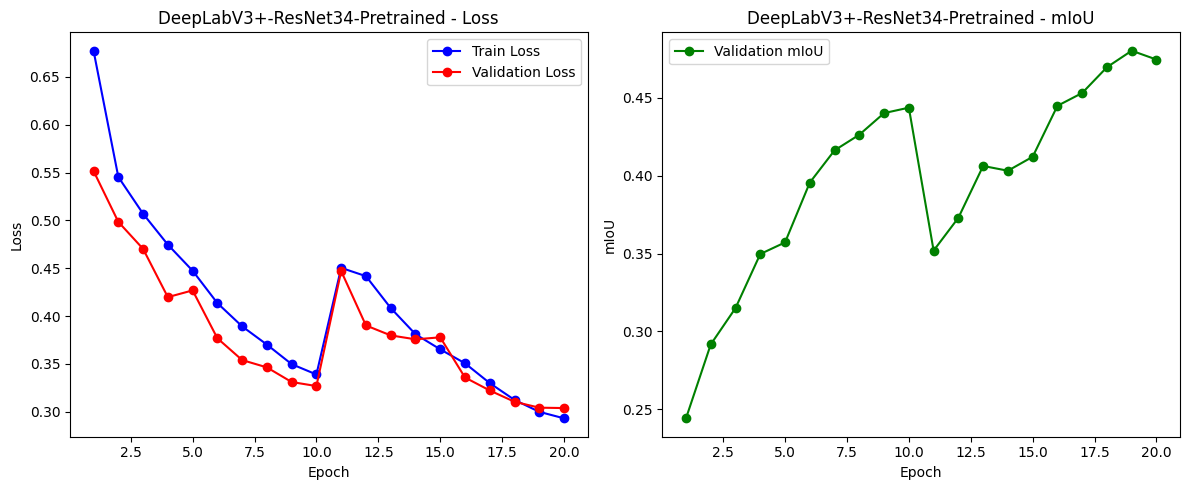

Training model: DeepLabV3+-ResNet50-Pretrained


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 1/20
Train Loss: 0.6757
Validation Loss: 0.5803
Validation mIoU: 0.2548


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 2/20
Train Loss: 0.5551
Validation Loss: 0.5428
Validation mIoU: 0.2533


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 3/20
Train Loss: 0.5166
Validation Loss: 0.4527
Validation mIoU: 0.3283


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 4/20
Train Loss: 0.4790
Validation Loss: 0.4492
Validation mIoU: 0.3325


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 5/20
Train Loss: 0.4504
Validation Loss: 0.4420
Validation mIoU: 0.3422


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 6/20
Train Loss: 0.4319
Validation Loss: 0.3971
Validation mIoU: 0.3624


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 7/20
Train Loss: 0.3997
Validation Loss: 0.3836
Validation mIoU: 0.3828


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 8/20
Train Loss: 0.3821
Validation Loss: 0.3568
Validation mIoU: 0.4175


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 9/20
Train Loss: 0.3584
Validation Loss: 0.3386
Validation mIoU: 0.4308


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 10/20
Train Loss: 0.3450
Validation Loss: 0.3327
Validation mIoU: 0.4392


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 11/20
Train Loss: 0.4554
Validation Loss: 0.4460
Validation mIoU: 0.3672


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 12/20
Train Loss: 0.4369
Validation Loss: 0.4705
Validation mIoU: 0.3184


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 13/20
Train Loss: 0.4238
Validation Loss: 0.4168
Validation mIoU: 0.3622


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 14/20
Train Loss: 0.4081
Validation Loss: 0.3744
Validation mIoU: 0.4217


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 15/20
Train Loss: 0.3819
Validation Loss: 0.3611
Validation mIoU: 0.4144


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 16/20
Train Loss: 0.3585
Validation Loss: 0.3391
Validation mIoU: 0.4426


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 17/20
Train Loss: 0.3376
Validation Loss: 0.3341
Validation mIoU: 0.4368


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 18/20
Train Loss: 0.3219
Validation Loss: 0.3221
Validation mIoU: 0.4515


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 19/20
Train Loss: 0.3090
Validation Loss: 0.3092
Validation mIoU: 0.4667


<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


Epoch 20/20
Train Loss: 0.3001
Validation Loss: 0.3077
Validation mIoU: 0.4702


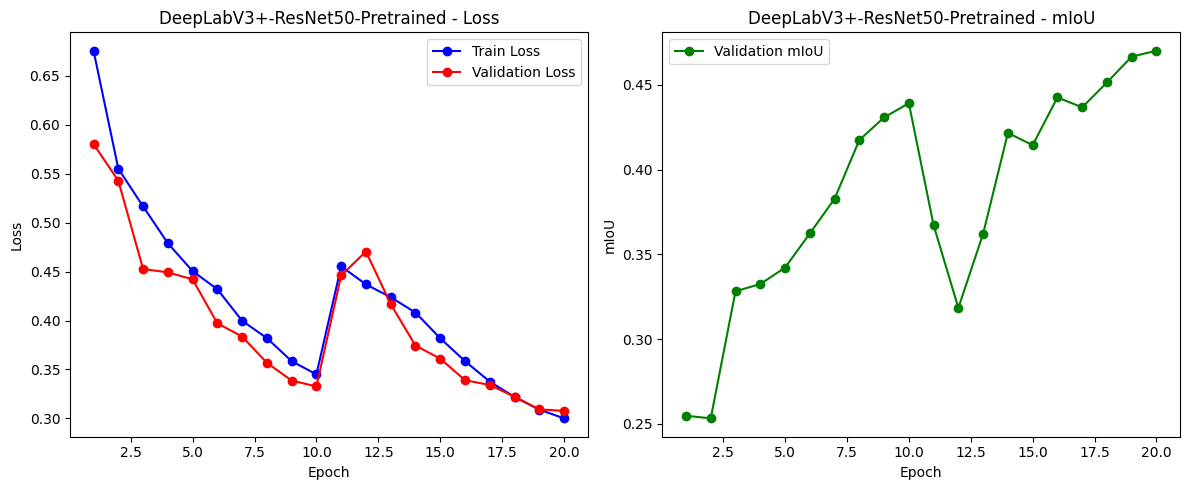

In [28]:
num_epochs = 20

for model_name, model in models.items():
    print(f'Training model: {model_name}')

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []
    val_mIoUs = []

    try:
        for epoch in range(num_epochs):
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_preds, val_targets = val_epoch(model, val_loader, criterion, device)
            val_mIoU = calculate_mIoU(val_preds, val_targets, num_classes=7)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            val_mIoUs.append(val_mIoU)

            print(f'Epoch {epoch+1}/{num_epochs}')
            print(f'Train Loss: {train_loss:.4f}')
            print(f'Validation Loss: {val_loss:.4f}')
            print(f'Validation mIoU: {val_mIoU:.4f}')

            scheduler.step()

        # Визуализация потерь и метрик
        plot_metrics(train_losses, val_losses, val_mIoUs, model_name)

    except Exception as e:
        print(f"An error occurred during the training of {model_name}: {str(e)}")
        # Сохранение текущих весов модели при ошибке
        save_model_weights(model, model_name, epoch)
        break

In [29]:
def save_all_models(models, save_dir='models'):
    os.makedirs(save_dir, exist_ok=True)

    for model_name, model in models.items():
        model_path = os.path.join(save_dir, f'{model_name}.pth')
        torch.save(model.state_dict(), model_path)
        print(f'Weights of model {model_name} saved to {model_path}')

save_all_models(models, save_dir='models')

Weights of model UNet-ResNet34-Scratch saved to models/UNet-ResNet34-Scratch.pth
Weights of model UNet-ResNet50-Scratch saved to models/UNet-ResNet50-Scratch.pth
Weights of model UNet-ResNet34-Pretrained saved to models/UNet-ResNet34-Pretrained.pth
Weights of model UNet-ResNet50-Pretrained saved to models/UNet-ResNet50-Pretrained.pth
Weights of model DeepLabV3+-ResNet34-Scratch saved to models/DeepLabV3+-ResNet34-Scratch.pth
Weights of model DeepLabV3+-ResNet50-Scratch saved to models/DeepLabV3+-ResNet50-Scratch.pth
Weights of model DeepLabV3+-ResNet34-Pretrained saved to models/DeepLabV3+-ResNet34-Pretrained.pth
Weights of model DeepLabV3+-ResNet50-Pretrained saved to models/DeepLabV3+-ResNet50-Pretrained.pth


In [31]:
# Список моделей и соответствующих путей к их весам
model_paths = {
    "UNet-ResNet34-Scratch": "models/UNet-ResNet34-Scratch.pth",
    "UNet-ResNet50-Scratch": "models/UNet-ResNet50-Scratch.pth",
    "UNet-ResNet34-Pretrained": "models/UNet-ResNet34-Pretrained.pth",
    "UNet-ResNet50-Pretrained": "models/UNet-ResNet50-Pretrained.pth",
    "DeepLabV3+-ResNet34-Scratch": "models/DeepLabV3+-ResNet34-Scratch.pth",
    "DeepLabV3+-ResNet50-Scratch": "models/DeepLabV3+-ResNet50-Scratch.pth",
    "DeepLabV3+-ResNet34-Pretrained": "models/DeepLabV3+-ResNet34-Pretrained.pth",
    "DeepLabV3+-ResNet50-Pretrained": "models/DeepLabV3+-ResNet50-Pretrained.pth"
}

In [33]:
# Функция для вычисления mIoU для каждого уровня
def calculate_mIoUs(model, val_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(masks.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    mIoU_0 = calculate_mIoU(all_preds, all_targets, [1, 2, 3, 4, 5, 6])  # Уровень body
    mIoU_1 = calculate_mIoU(all_preds, all_targets, [1, 2])  # Уровень upper_body, lower_body
    mIoU_2 = calculate_mIoU(all_preds, all_targets, [1, 6, 2, 4, 3, 5])  # Уровень low_hand, up_hand, torso, head, low_leg, up_leg

    return mIoU_0, mIoU_1, mIoU_2


In [35]:
def calculate_mIoU(preds, targets, classes):
    ious = []
    for cls in classes:
        pred_mask = (preds == cls)
        true_mask = (targets == cls)
        iou = jaccard_score(true_mask.flatten(), pred_mask.flatten(), zero_division=0)
        ious.append(iou)
    return np.mean(ious)

In [36]:
# Загрузка моделей и вычисление mIoU для каждой
model_mIoUs = {}

for model_name, model_path in model_paths.items():
    model = models[model_name]
    model.load_state_dict(torch.load(model_path))

    mIoU_0, mIoU_1, mIoU_2 = calculate_mIoUs(model, val_loader, device)
    model_mIoUs[model_name] = {"mIoU_0": mIoU_0, "mIoU_1": mIoU_1, "mIoU_2": mIoU_2}

print(model_mIoUs)

<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)
<ipython-input-21-4e9f37b18c91>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detac

{'UNet-ResNet34-Scratch': {'mIoU_0': 0.1654363954117055, 'mIoU_1': 0.23588670345593227, 'mIoU_2': 0.1654363954117055}, 'UNet-ResNet50-Scratch': {'mIoU_0': 0.14732454061378902, 'mIoU_1': 0.20792553199647412, 'mIoU_2': 0.147324540613789}, 'UNet-ResNet34-Pretrained': {'mIoU_0': 0.39390346717005165, 'mIoU_1': 0.40951314947443507, 'mIoU_2': 0.39390346717005165}, 'UNet-ResNet50-Pretrained': {'mIoU_0': 0.36587219116128383, 'mIoU_1': 0.3941579906525071, 'mIoU_2': 0.36587219116128383}, 'DeepLabV3+-ResNet34-Scratch': {'mIoU_0': 0.16918987854439768, 'mIoU_1': 0.22379043237269963, 'mIoU_2': 0.16918987854439768}, 'DeepLabV3+-ResNet50-Scratch': {'mIoU_0': 0.18429783880406017, 'mIoU_1': 0.238680218150117, 'mIoU_2': 0.18429783880406023}, 'DeepLabV3+-ResNet34-Pretrained': {'mIoU_0': 0.40084820861443476, 'mIoU_1': 0.41541864836315845, 'mIoU_2': 0.40084820861443476}, 'DeepLabV3+-ResNet50-Pretrained': {'mIoU_0': 0.39565855029866936, 'mIoU_1': 0.4140316502140068, 'mIoU_2': 0.39565855029866936}}


                                  mIoU_0    mIoU_1    mIoU_2
UNet-ResNet34-Scratch           0.165436  0.235887  0.165436
UNet-ResNet50-Scratch           0.147325  0.207926  0.147325
UNet-ResNet34-Pretrained        0.393903  0.409513  0.393903
UNet-ResNet50-Pretrained        0.365872  0.394158  0.365872
DeepLabV3+-ResNet34-Scratch     0.169190  0.223790  0.169190
DeepLabV3+-ResNet50-Scratch     0.184298  0.238680  0.184298
DeepLabV3+-ResNet34-Pretrained  0.400848  0.415419  0.400848
DeepLabV3+-ResNet50-Pretrained  0.395659  0.414032  0.395659


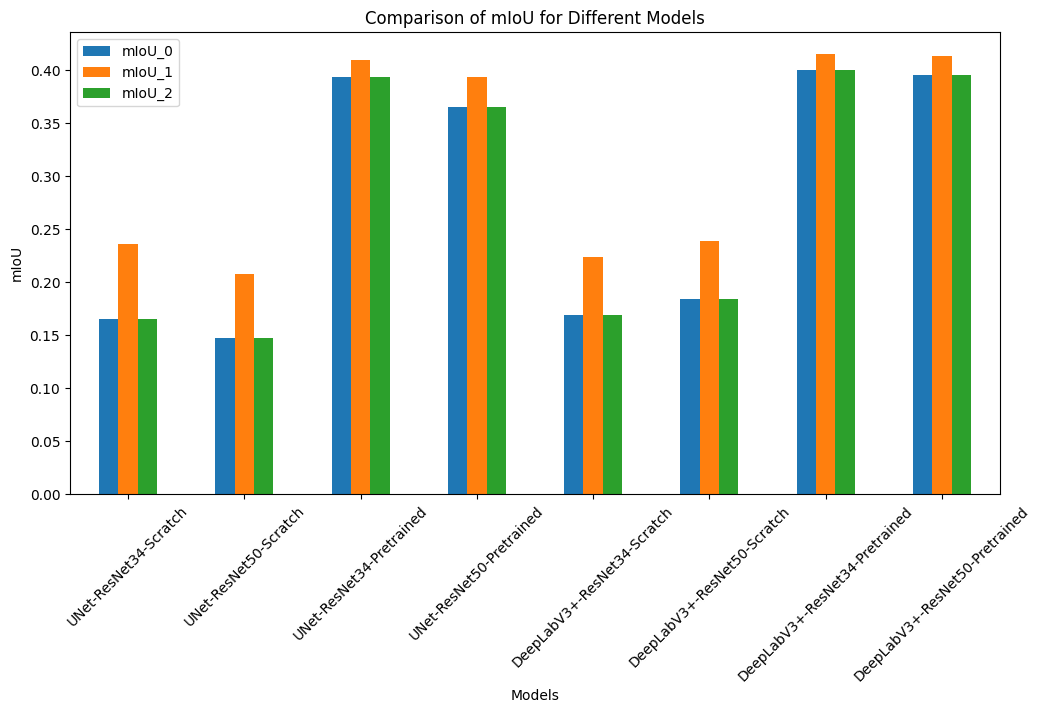

In [37]:
import pandas as pd

mIoU_df = pd.DataFrame.from_dict(model_mIoUs, orient='index')
print(mIoU_df)

mIoU_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of mIoU for Different Models')
plt.ylabel('mIoU')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()